# Log Analysis and Visulization 2020-02-26

## a) parse log file

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import os
import shutil
import datetime

In [2]:
# read the log file
def is_json(myjson):
    try:
        json_object = json.loads(myjson)
    except ValueError as e:
        return False
    return True
 
def read_data(files, path):
    data = []
    for file in files:
        with open(path + file, errors='ignore') as f:
            for line in f.readlines():
                try: 
                    if not is_json(line):
                        continue
                    data.append(json.loads(line))
                except:
                    print('bad json: ', line)
    return data

## b) data processing and analysis

In [3]:
# convert the data into pandas dataframe
def data_processing(data):
    df = pd.DataFrame(data) 

    # convert all the keys in the staking into columns, fill nan values
    df = pd.concat([df.drop(['staking'], axis=1), df['staking'].apply(pd.Series)], axis=1)
    df.fillna(0, inplace = True)

    # drop duplicates
    df.drop_duplicates(inplace = True)

    # sort by timestamp 
    df.sort_values(by=['timestamp'], inplace = True)

    # convert timestamp to datetime64[ns] 
    df["timestamp"] = df["timestamp"].apply(lambda t: t.replace(" +0000 UTC",""))
    df["timestamp"] = pd.to_datetime(df['timestamp'])
    df['utc_time'] = df['timestamp'].dt.time
    
    df["log_size"] = df.apply(lambda c: np.log(c["size"]) if c["size"] != 0 else 0, axis = 1)
    df["log_gas"] = df.apply(lambda c: np.log(c["gas"]) if c["gas"] != 0 else 0, axis = 1)
    
    # do calculation for each shard
    shard = []
    for name, s in df.groupby("shard"):
        shard.append(s.reset_index(drop = True))
    
    # calculate the average time per block, transaction_per_second
    for s in shard:
        # time per block
        s["time_diff"] = (s['timestamp']-s['timestamp'].shift()).fillna(pd.Timedelta(seconds=0))
        s["block_diff"] = (s['block']-s['block'].shift()).fillna(0).astype(int)
        s["time_per_block"] = s.apply(lambda c: c["time_diff"].seconds /c["block_diff"] \
                                      if c["block_diff"] != 0 else np.nan, axis = 1)

        # plain transaction_per_second
        s["transaction_per_second"] = s.apply(lambda c: c["transactions"]/c["time_diff"].seconds  \
                                              if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        # staking transaction_per_second
        s["staking_transaction_per_second"] = s.apply(lambda c: c["total"]/c["time_diff"].seconds \
                                              if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        # total transacton per second
        s["total_transaction_per_second"] = s["transaction_per_second"] + s["staking_transaction_per_second"]

        # info for staking
        s.rename(columns={"total": "total_staking"}, inplace = True)
        if "CreateValidator" in s.columns:
            # create validator per second
            s["create_validator_per_second"] = s.apply(lambda c: c["CreateValidator"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        if "EditValidator" in s.columns:
            # edit validator per second
            s["edit_validator_per_second"] = s.apply(lambda c: c["EditValidator"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        if "Delegate" in s.columns:
            # delegate per second
            s["delegate_per_second"] = s.apply(lambda c: c["Delegate"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        if "Undelegate" in s.columns:
            # undelegate per second
            s["undelegate_per_second"] = s.apply(lambda c: c["Undelegate"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
        if "CollectRewards" in s.columns:
            # CollectRewards per second
            s["collect_rewards_per_second"] = s.apply(lambda c: c["CollectRewards"]/c["time_diff"].seconds \
                                                       if c["time_diff"].seconds != 0 else np.nan, axis = 1)
            
        s.drop(['time_diff', 'block_diff'], axis=1, inplace = True)
        
    return shard

## c) draw the graph 

In [4]:
# draw the graphs with x-axis time
def draw_graph_time(shard, fig_path):
    df = pd.concat(shard)
    
    sns.set(style="whitegrid", font_scale = 1.8)
    colors = ["#00AEE9","#758796","#1B295E"]
    new_palette = sns.set_palette(colors)
    
    fig = plt.figure(figsize=(20, 10))
    ax = sns.lineplot(x="utc_time", y="transaction_per_second", hue="shard", data=df)
    ax.set_title('Transaction Per Second vs Time ')
    fig.savefig(fig_path + "transaction_per_second_vs_time.png")
    plt.show()
    
    fig = plt.figure(figsize=(20, 10))
    ax = sns.lineplot(x="utc_time", y="time_per_block", hue="shard", data=df)
    ax.set_title('Time Per Block vs Time ')
    fig.savefig(fig_path + "time_per_block_vs_time.png")
    plt.show()
    
    fig = plt.figure(figsize=(20, 10))
    ax = sns.lineplot(x="utc_time", y="size", hue="shard", data=df)
    ax.set_title("Size vs Time ")
    fig.savefig(fig_path + "size_vs_time.png")
    plt.show()
    
    fig = plt.figure(figsize=(20, 10))
    ax = sns.lineplot(x="utc_time", y="gas", hue="shard", data=df)
    ax.set_title("Gas vs Time ")
    fig.savefig(fig_path + "gas_vs_time.png")
    plt.show()

In [5]:
# draw the graphs with x-axis block height
def draw_graph_block(shard, fig_path):
    df = pd.concat(shard)
    
    sns.set(style="whitegrid", font_scale = 1.8)
    colors = ["#00AEE9","#758796", "#1B295E"]
    sns.set_palette(sns.color_palette(colors))
    
    fig = plt.figure(figsize=(20, 10))
    ax = sns.lineplot(x="block", y="transaction_per_second", hue="shard", data=df)
    ax.set_title('Transaction Per Second vs Block Height ')
    fig.savefig(fig_path + "transaction_per_second_vs_block_height.png")
    plt.show()
    
    fig = plt.figure(figsize=(20, 10))
    ax = sns.lineplot(x="block", y="time_per_block", hue="shard", data=df)
    ax.set_title('Time Per Block vs Block Height ')
    fig.savefig(fig_path + "time_per_block_vs_block_height.png")
    plt.show()
    
    fig = plt.figure(figsize=(20, 10))
    ax = sns.lineplot(x="block", y="size", hue="shard", data=df)
    ax.set_title("Size vs Block Height ")
    fig.savefig(fig_path + "size_vs_block_height.png")
    plt.show()
    
    fig = plt.figure(figsize=(20, 10))
    ax = sns.lineplot(x="block", y="gas", hue="shard", data=df)
    ax.set_title("Gas vs Block Height ")
    ax = fig.savefig(fig_path + "gas_vs_block_height.png")
    plt.show()

# Result
- transaction per second vs time 
- time per block vs time
- size vs time
- gas vs time
- transaction per second vs block height
- time per block vs block height
- size vs block height
- gas vs block height

statistics summary for shard 0
Total data points: 1643
               size           gas  transaction_per_second  time_per_block
mean   42466.610469  3.821031e+06                9.640491       10.021924
std    80933.841745  6.118281e+06               16.446549        6.066145
min      696.000000  0.000000e+00                0.000000        8.000000
25%      702.000000  0.000000e+00                0.000000        8.000000
50%    15467.000000  3.360000e+05                0.555556        9.000000
75%    51292.500000  7.570500e+06                9.885417        9.000000
max   458370.000000  3.131016e+07               62.375000      152.000000

statistics summary for shard 1
Total data points: 1255
               size           gas  transaction_per_second  time_per_block
mean   44295.651793  6.703032e+06               28.605515       10.109041
std    35995.494827  5.346758e+06               23.091273        3.195612
min      696.000000  0.000000e+00                0.000000        8.000000
2

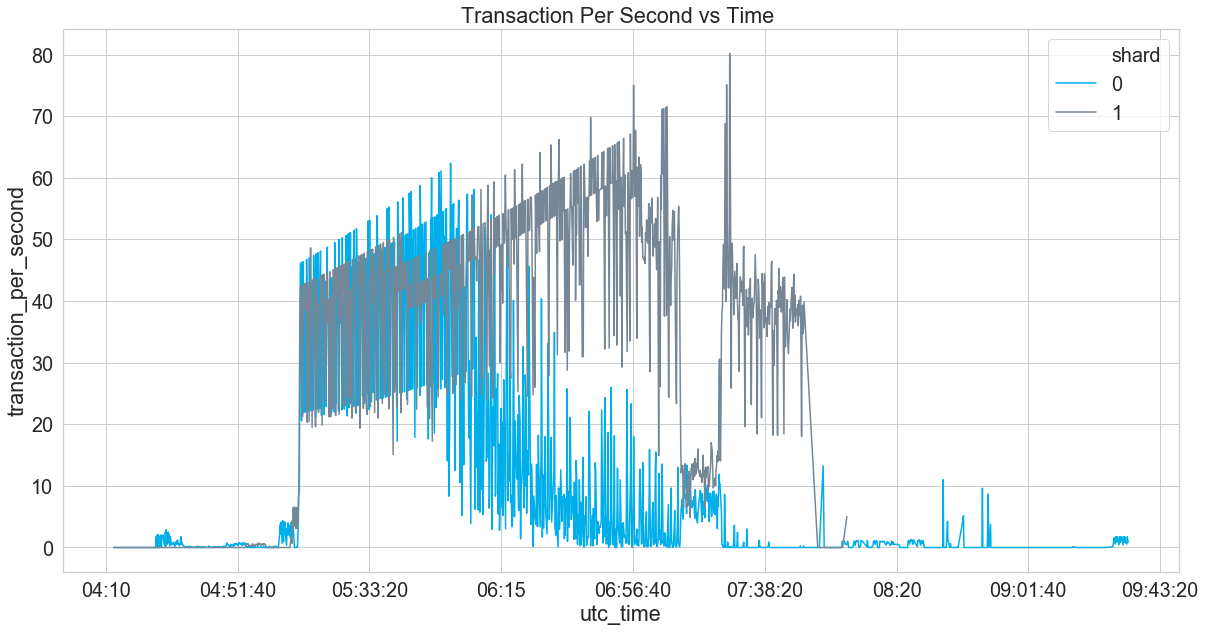

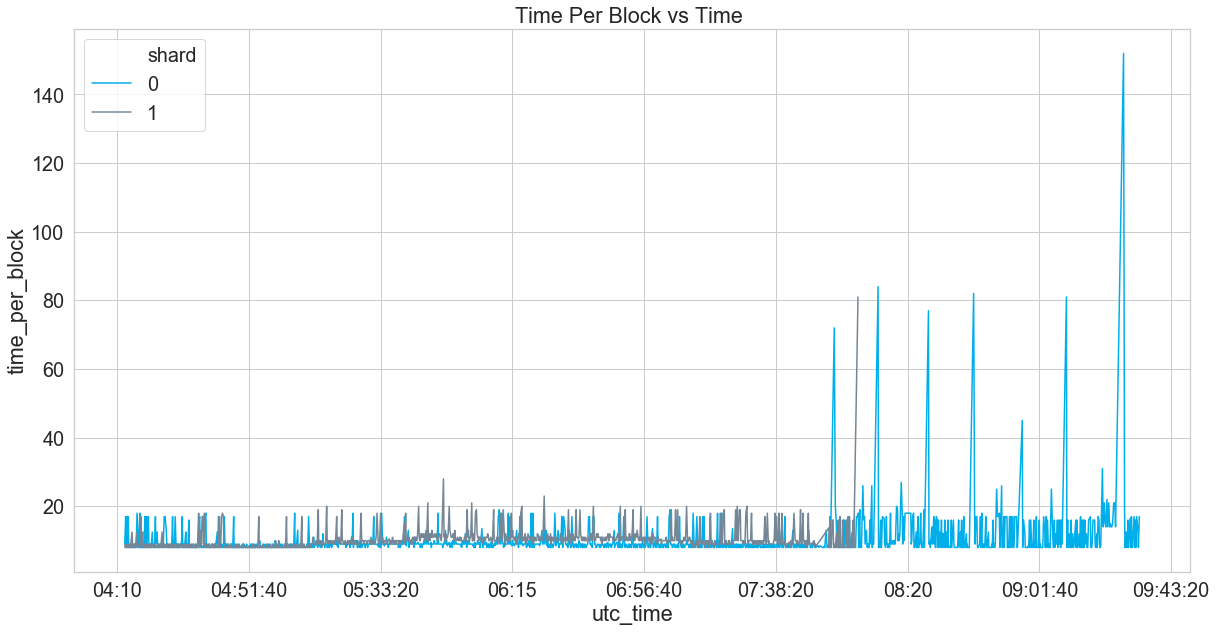

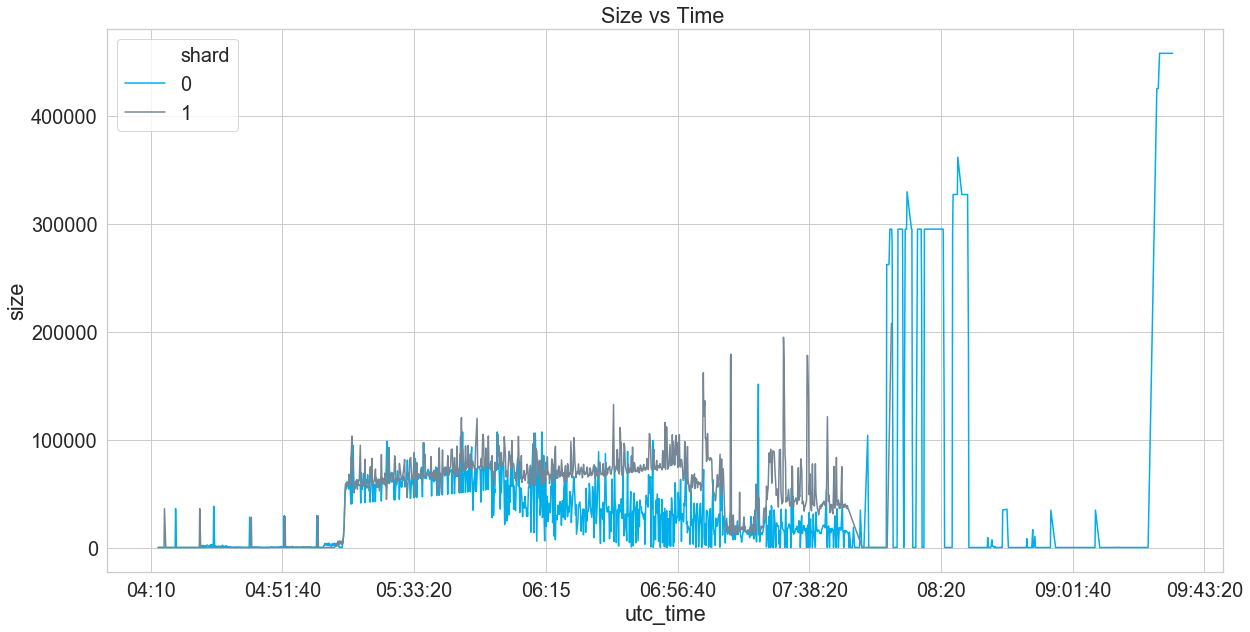

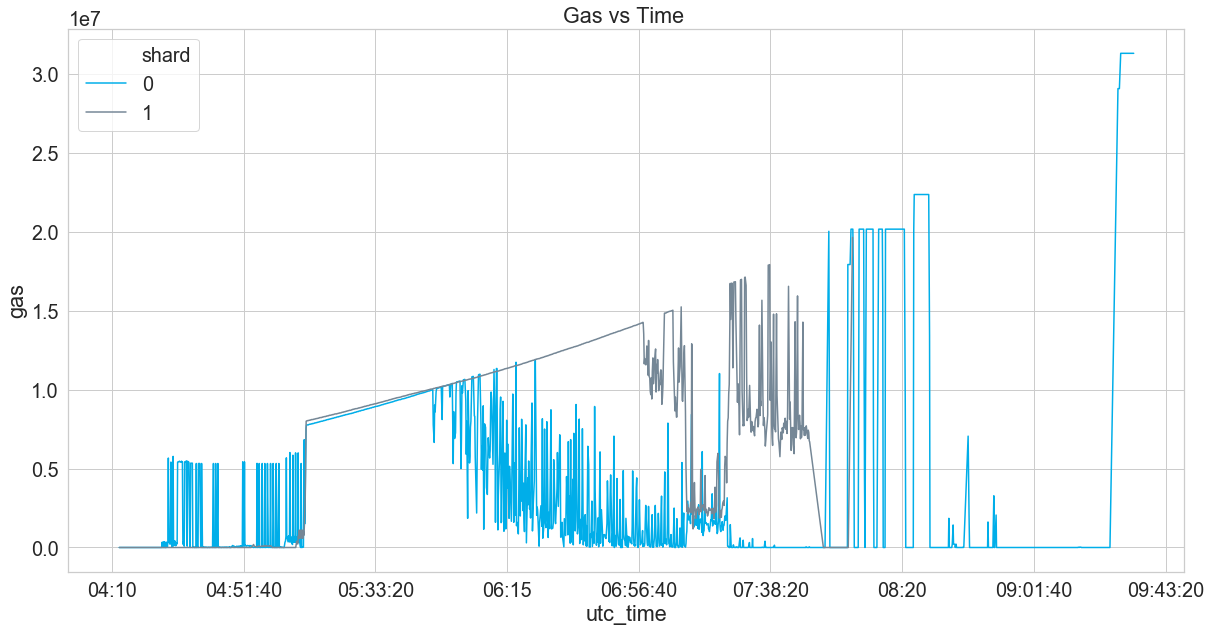

Features vs Block Height


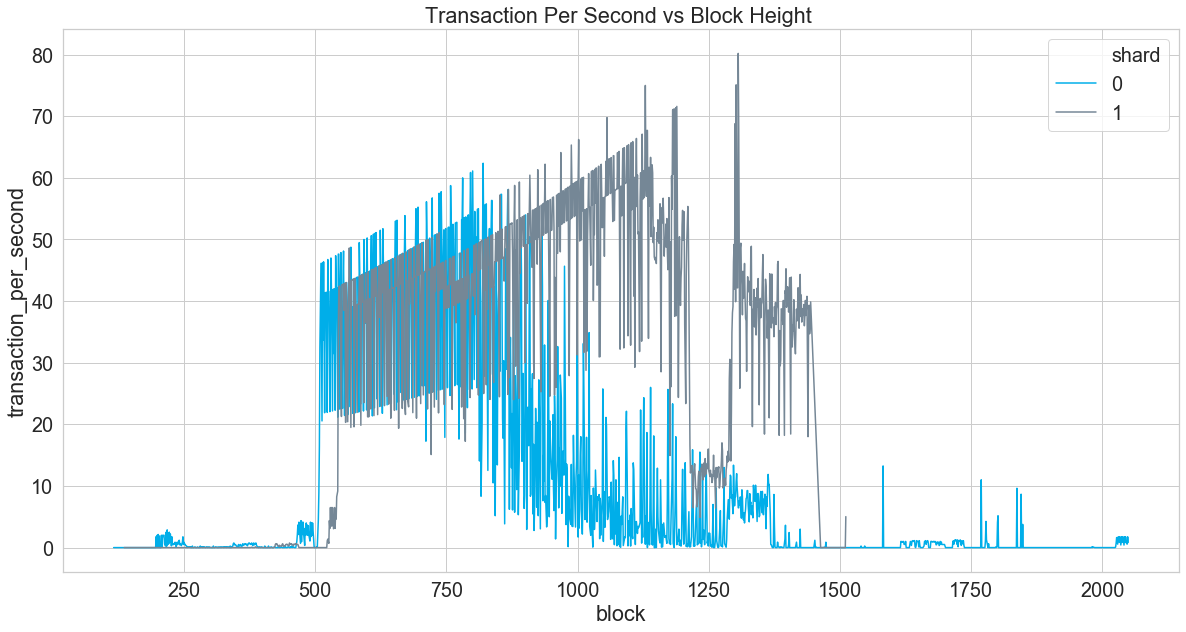

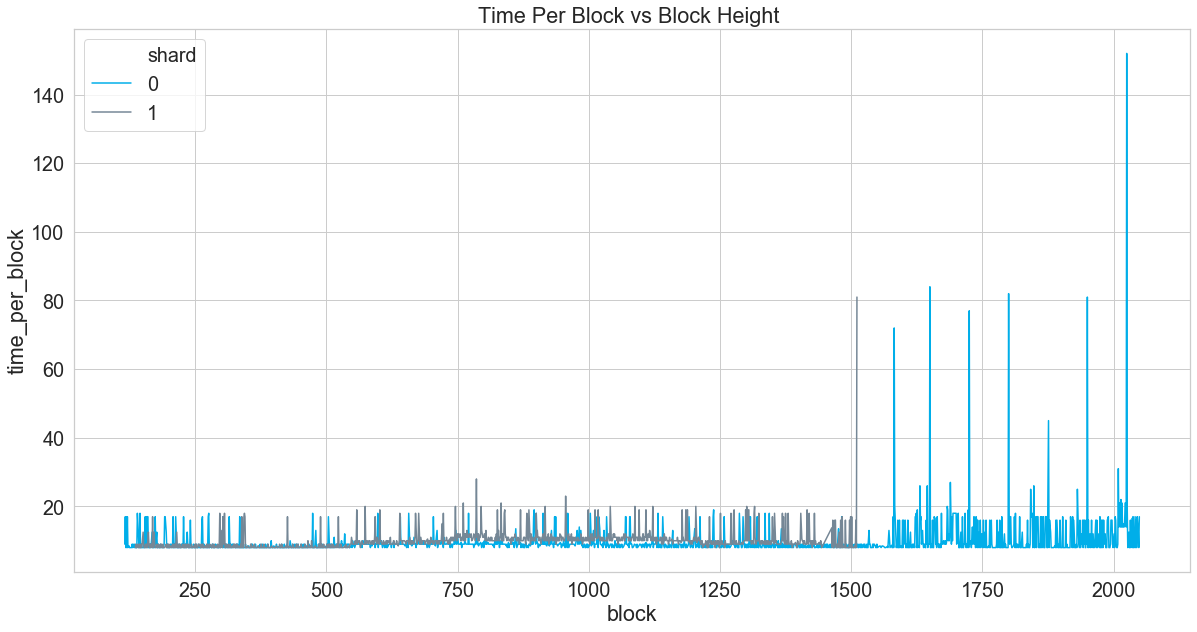

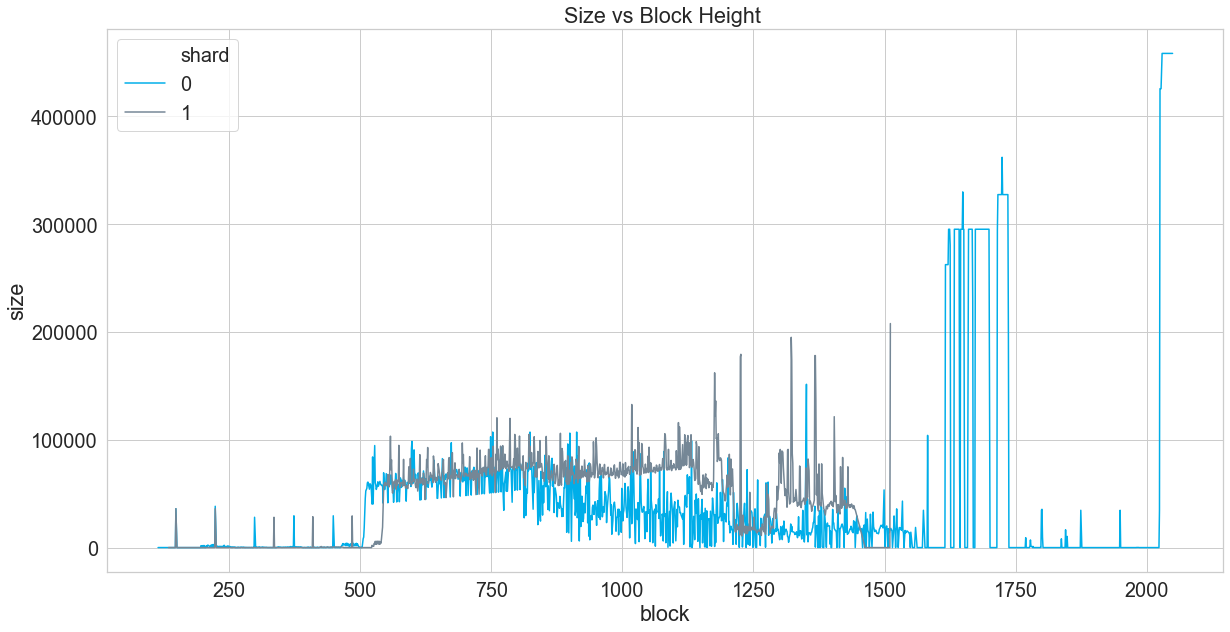

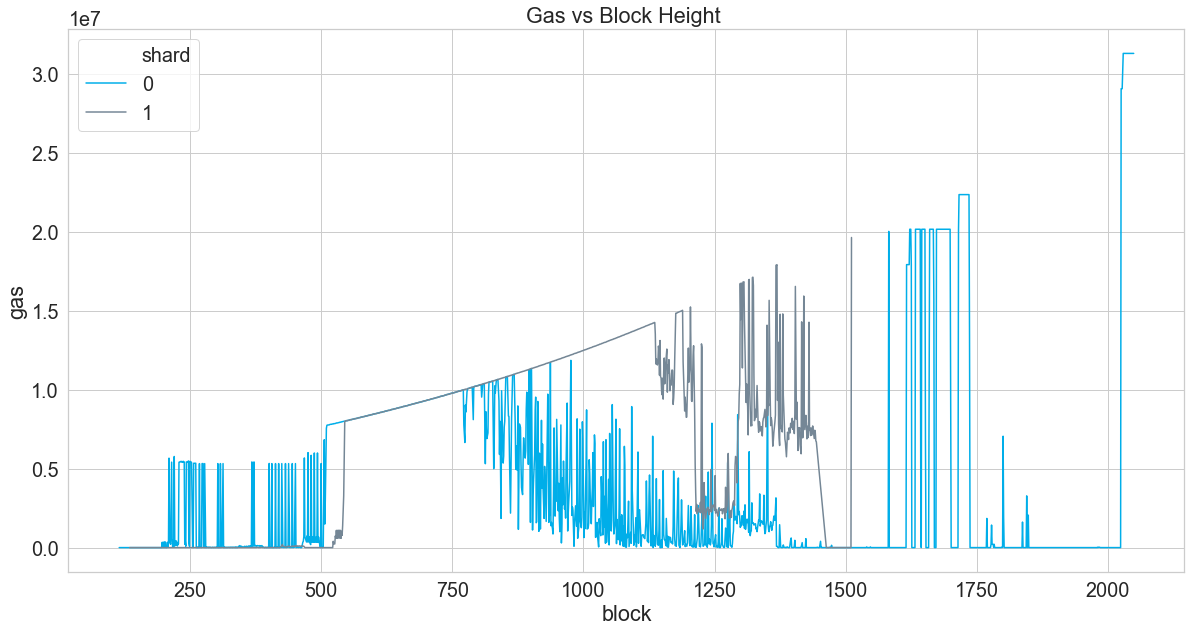

In [6]:
if __name__ == '__main__':
    log_path = "../../logs/test_logs/stress_test_02_26/"
    fig_path = "../../graphs/test_logs/stress_test_02_26/static/"
    files = os.listdir(log_path)
    data = read_data(files, log_path)
    shard = data_processing(data)
    new = pd.concat(shard)
    
    for name, group in new.groupby("shard"):
        print("statistics summary for shard " + str(name))
        print("==================================")
        summary = group[["size","gas","transaction_per_second","time_per_block"]].describe()
        print("Total data points: " + str(summary.iloc[0][0].astype(int)))
        print(summary.iloc[1:])
        print("")
        
    if os.path.exists(fig_path):
        shutil.rmtree(fig_path)
    os.mkdir(fig_path)
    print("Features vs Time")
    print("==================================")
    draw_graph_time(shard, fig_path)
    print("Features vs Block Height")
    print("==================================")
    draw_graph_block(shard, fig_path)
        